In [1]:
import os
import glob
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import xarray as xr
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import BoundaryNorm
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
import pandas as pd
import datetime
import copy
import metpy.calc as mpcalc
from metpy.units import units
# from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
# %matploblib inline

In [2]:
# iclassdir = '/global/project/projectdirs/m1657/zfeng/cacti/arm/csapr/'
# statsdir = f'/pscratch/sd/f/feng045/SAAG/hist/cell_tracking/2018/stats/'
statsdir = f'/pscratch/sd/f/feng045/SAAG/hist/cell_tracking/cacti/stats/'
# terrain_file = f'{iclassdir}corgridded_terrain.c0/topo_cacti_csapr2_large.nc'
stats_file = f'{statsdir}/trackstats_20181001.0000_20190302.0000.nc'
# sondeparam_file = f'{statsdir}Interpsonde_parameters_CACTI_AMF_2Oct-30Apr_v3.1.1.nc'
# sonde_file = f'/global/project/projectdirs/m1657/zfeng/cacti/arm/sounding_stats/corinterpolatedsondeM1.c1.20181001_20190430_resample3H.nc'
# rain_file = f'{statsdir}csapr2_domain_mean_rain_20181015_20190303.nc'

# radar_lat = -32.1264
# radar_lon = -64.7284
radar_lon, radar_lat = -64.75, -32.1

figdir = f'/pscratch/sd/f/feng045/SAAG/hist/cell_tracking/figures/'
# figdir_jointhist = f'{figdir}jointhist/'
os.makedirs(figdir, exist_ok=True)
# os.makedirs(figdir_jointhist, exist_ok=True)

In [3]:
# Read 2D track data
ds = xr.open_dataset(stats_file)
time_res = ds.attrs['time_resolution_hour']
pixel_radius = ds.attrs['pixel_radius_km']
print(ds.dims['tracks'])

29531


## Subset tracks

In [4]:
radius_deg = 1.0
lon_range = [radar_lon-radius_deg, radar_lon+radius_deg]
lat_range = [radar_lat-radius_deg, radar_lat+radius_deg]
lon_range, lat_range

([-65.75, -63.75], [-33.1, -31.1])

In [5]:
# Get track min/max lat/lon
minlon = ds['meanlon'].min(dim='times').load()
maxlon = ds['meanlon'].max(dim='times').load()
minlat = ds['meanlat'].min(dim='times').load()
maxlat = ds['meanlat'].max(dim='times').load()
# Subset tracks that are within boundary
ds = ds.where((minlon >= min(lon_range)) & (maxlon <= max(lon_range)) & \
              (minlat >= min(lat_range)) & (maxlat <= max(lat_range)), drop=True)
# Renumber tracks to make it continuous
ntracks = ds.sizes['tracks']
ds['tracks'] = np.arange(0, ntracks)
print(f'Number of tracks: {ntracks}')
ds

Number of tracks: 6709


<xarray.Dataset>
Dimensions:                  (tracks: 6709, times: 60)
Coordinates:
  * tracks                   (tracks) int64 0 1 2 3 4 ... 6705 6706 6707 6708
  * times                    (times) int64 0 1 2 3 4 5 6 ... 54 55 56 57 58 59
Data variables: (12/37)
    track_duration           (tracks) float64 2.0 4.0 3.0 4.0 ... 2.0 2.0 2.0
    base_time                (tracks, times) datetime64[ns] 2018-10-01T00:15:...
    meanlat                  (tracks, times) float32 -31.41 -31.45 ... nan nan
    meanlon                  (tracks, times) float32 -64.97 -64.84 ... nan nan
    area                     (tracks, times) float32 256.0 128.0 nan ... nan nan
    cloudnumber              (tracks, times) float64 5.0 19.0 nan ... nan nan
    ...                       ...
    start_split_tracknumber  (tracks) float64 nan nan nan nan ... nan nan nan
    start_split_timeindex    (tracks) float64 nan nan nan nan ... nan nan nan
    start_split_cloudnumber  (tracks) float64 nan nan nan nan ... nan nan nan
    end_merge_tracknumber    (tracks) float64 nan nan 8.0 nan ... nan nan nan
    end_merge_timeindex      (tracks) float64 nan nan 3.0 nan ... nan nan nan
    end_merge_cloudnumber    (tracks) float64 nan nan 2.0 nan ... nan nan nan
Attributes:
    Title:                 Statistics of each track
    Institution:           Pacific Northwest National Laboratory
    Contact:               Zhe Feng, zhe.feng@pnnl.gov
    Created_on:            Mon Feb 19 23:51:03 2024
    startdate:             20181001.0000
    enddate:               20190302.0000
    timegap_hour:          0.5
    time_resolution_hour:  0.25
    pixel_radius_km:       4.0

In [6]:
lifetime = ds['track_duration'] * time_res
start_time = ds['start_basetime']
end_time = ds['end_basetime']
end_merge_tracknumber = ds['end_merge_tracknumber']
start_split_tracknumber = ds['start_split_tracknumber']
cell_lon = ds['cell_meanlon']
cell_lat = ds['cell_meanlat']
cell_area = ds['cell_area']
maxrange_flag = ds['maxrange_flag']
max_dbz = ds['max_dbz']

In [7]:
# Get track start values
start_maxrange_flag = maxrange_flag.isel(times=0)
start_lon = cell_lon.isel(times=0)
start_lat = cell_lat.isel(times=0)

# Get duration (lifetime counts) and maxrange_flag in Numpy arrays for speed
duration = (lifetime.values / time_res).astype(int)
rangeflag = maxrange_flag.values.astype(int)
celllon = cell_lon.values
celllat = cell_lat.values

# end_maxrange_flag = np.ones(ntracks, dtype=int)
# end_lon = np.full(ntracks, np.NaN, dtype=float)
# end_lat = np.full(ntracks, np.NaN, dtype=float)

# # Get track last valid value
# for ii in range(0, ntracks):
#     # Get duration for the track
#     iduration = duration[ii]
#     # Get valid values for the track
#     imaxrangeflag = rangeflag[ii,0:iduration]
#     icell_lon = celllon[ii,0:iduration]
#     icell_lat = celllat[ii,0:iduration]
    
#     # Get last value from the track
#     end_maxrange_flag[ii] = imaxrangeflag[-1]
#     end_lon[ii] = icell_lon[-1]
#     end_lat[ii] = icell_lat[-1]

In [8]:
# Get track start/end hour
start_hour = start_time.dt.hour
end_hour = end_time.dt.hour

cell_diam = 2 * np.sqrt(cell_area / np.pi)
cell_diam_max = cell_diam.max(dim='times')
cell_area_max = cell_area.max(dim='times')
# cell_eth20_max = eth20.max(dim='times')

In [9]:
# Create a standard time series bins
date_ts = pd.date_range(start='2018-10-15T00', end='2019-03-02T23', freq='6H')
# date_ts = pd.date_range(start='2018-11-01T00', end='2019-01-01T00', freq='6H')
# Make bounds for pcolormesh
date_ts_bounds = pd.date_range(start='2018-10-15T00', end='2019-03-03T00', freq='6H')
# date_ts_bounds = pd.date_range(start='2018-11-01T00', end='2019-01-01T06', freq='6H')
ndate_ts = len(date_ts)
print(date_ts)
print(date_ts.shape, date_ts_bounds.shape)

DatetimeIndex(['2018-10-15 00:00:00', '2018-10-15 06:00:00',
               '2018-10-15 12:00:00', '2018-10-15 18:00:00',
               '2018-10-16 00:00:00', '2018-10-16 06:00:00',
               '2018-10-16 12:00:00', '2018-10-16 18:00:00',
               '2018-10-17 00:00:00', '2018-10-17 06:00:00',
               ...
               '2019-02-28 12:00:00', '2019-02-28 18:00:00',
               '2019-03-01 00:00:00', '2019-03-01 06:00:00',
               '2019-03-01 12:00:00', '2019-03-01 18:00:00',
               '2019-03-02 00:00:00', '2019-03-02 06:00:00',
               '2019-03-02 12:00:00', '2019-03-02 18:00:00'],
              dtype='datetime64[ns]', length=556, freq='6H')
(556,) (557,)


In [11]:
# Approximate longitude of SDC ridge
# lon_SDC = -64.9
# lon_eSDC = [-64.9, -63.]
lon_SDC = -65
lon_eSDC = [-65, -63]
idx_eSDC = np.where(start_lon > lon_SDC)[0]
idx_wSDC = np.where(start_lon <= lon_SDC)[0]
ntracks_e = len(idx_eSDC)
ntracks_w = len(idx_wSDC)
print(f'E.SDC ntracks: {ntracks_e}, W.SDC ntracks: {ntracks_w}')

start_time_e = start_time.isel(tracks=idx_eSDC)
start_time_w = start_time.isel(tracks=idx_wSDC)

E.SDC ntracks: 4218, W.SDC ntracks: 2491


In [12]:
bins_area = np.arange(1.6, 4.01, 0.12)
bins_diam = np.arange(6, 50.1, 2)
bins_eth = np.arange(1, 20.1, 1)
nbins_diam = len(bins_diam)
nbins_area = len(bins_area)
nbins_eth = len(bins_eth)
pdf_celldiam, bins = np.histogram(cell_diam_max, bins=bins_diam, density=True)
pdf_cellarea, bins = np.histogram(np.log10(cell_area_max), bins=bins_area, density=True)
# pdf_eth20, bins = np.histogram(cell_eth20_max, bins=bins_eth, density=True)

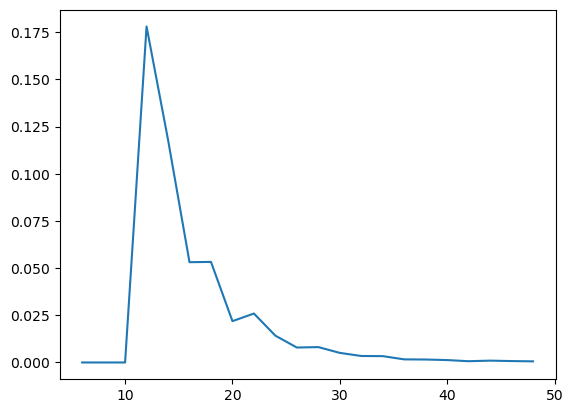

In [13]:
plt.plot(bins_diam[:-1], pdf_celldiam)

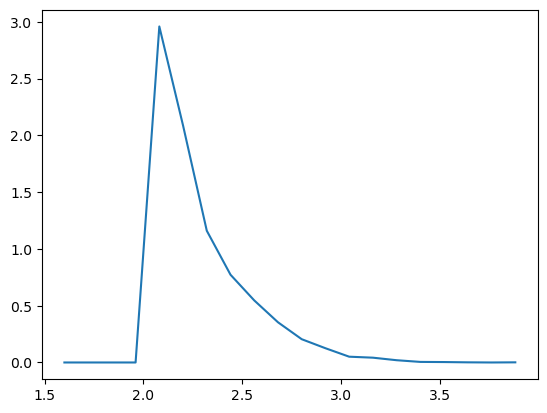

In [14]:
plt.plot(bins_area[:-1], pdf_cellarea)

In [23]:
ntracks_merge = np.count_nonzero(~np.isnan(end_merge_tracknumber))
ntracks_split = np.count_nonzero(~np.isnan(start_split_tracknumber))
ntracks_nomergesplit = np.count_nonzero((np.isnan(end_merge_tracknumber)) & (np.isnan(start_split_tracknumber)))
print(f'Merge track number: {ntracks_merge}, {(100*ntracks_merge/ntracks):.0f}%')
print(f'Split track number: {ntracks_split}, {(100*ntracks_split/ntracks):.0f}%')
print(f'Non-merge & non-split track number: {ntracks_nomergesplit}, {(100*ntracks_nomergesplit/ntracks):.0f}%')

Merge track number: 2426, 36%
Split track number: 2587, 39%
Non-merge & non-split track number: 2959, 44%


In [25]:
# Find tracks not end with merge or not start with split
nonmerge = np.where(np.isnan(end_merge_tracknumber))[0]
nonsplit = np.where(np.isnan(start_split_tracknumber))[0]
ntracks_nonmerge = len(nonmerge)
ntracks_nonsplit = len(nonsplit)
print(f'Number of non-merge tracks: {ntracks_nonmerge}, {(100*ntracks_nonmerge/ntracks):.0f}%')
print(f'Number of non-split tracks: {ntracks_nonsplit}, {(100*ntracks_nonsplit/ntracks):.0f}%')

# nonsplit_in = np.where(np.isnan(start_split_tracknumber) & (start_maxrange_flag == 1))[0]
# nonmerge_in = np.where(np.isnan(end_merge_tracknumber) & (end_maxrange_flag == 1))[0]
# ntracks_nonsplit_in = len(nonsplit_in)
# ntracks_nonmerge_in = len(nonmerge_in)
# print(f'Number of non-split tracks within max range: {ntracks_nonsplit_in}')
# print(f'Number of non-merge tracks within max range: {ntracks_nonmerge_in}')

merge = np.where(end_merge_tracknumber > 0)[0]
split = np.where(start_split_tracknumber > 0)[0]
ntracks_merge = len(merge)
ntracks_split = len(split)
print(f'Number of merge tracks: {ntracks_merge}, {(100*ntracks_merge/ntracks):.0f}%')
print(f'Number of split tracks: {ntracks_split}, {(100*ntracks_split/ntracks):.0f}%')

Number of non-merge tracks: 4283, 64%
Number of non-split tracks: 4122, 61%
Number of merge tracks: 2426, 36%
Number of split tracks: 2587, 39%


In [14]:
ntracks_ts = np.full(ndate_ts, np.nan, dtype=float)
ntracks_e_ts = np.full(ndate_ts, np.nan, dtype=float)
ntracks_w_ts = np.full(ndate_ts, np.nan, dtype=float)
cellarea_avg_ts = np.full(ndate_ts, 0, dtype=float)
celldiam_avg_ts = np.full(ndate_ts, 0, dtype=float)
celldiam_pdf_ts = np.full((nbins_diam-1, ndate_ts), 0, dtype=float)
cellarea_pdf_ts = np.full((nbins_area-1, ndate_ts), 0, dtype=float)
# celleth20_pdf_ts = np.full((nbins_eth-1, ndate_ts), 0, dtype=float)

for ii in range(ndate_ts-1):
#     print(date_ts[ii])
    idx = np.where((start_time.values >= date_ts[ii]) & (start_time.values < date_ts[ii+1]))[0]
    idx_e = np.where((start_time_e.values >= date_ts[ii]) & (start_time_e.values < date_ts[ii+1]))[0]
    idx_w = np.where((start_time_w.values >= date_ts[ii]) & (start_time_w.values < date_ts[ii+1]))[0]
    count = len(idx)
    count_e = len(idx_e)
    count_w = len(idx_w)
    ntracks_ts[ii] = count
    ntracks_e_ts[ii] = count_e
    ntracks_w_ts[ii] = count_w
#     if count > 0:
    icellarea = cell_area_max.isel(tracks=idx)
    icelldiam = cell_diam_max.isel(tracks=idx)
    # ieth20 = cell_eth20_max.isel(tracks=idx)
    cellarea_avg_ts[ii] = np.nanmean(icellarea)
    celldiam_avg_ts[ii] = np.nanmean(icelldiam)
    ipdf, bins = np.histogram(icelldiam, bins=bins_diam, density=False)
    celldiam_pdf_ts[:,ii] = ipdf
    ipdf, bins = np.histogram(np.log10(icellarea), bins=bins_area, density=False)
    cellarea_pdf_ts[:,ii] = ipdf
    # ipdf, bins = np.histogram(ieth20, bins=bins_eth, density=False)
    # celleth20_pdf_ts[:,ii] = ipdf

/tmp/ipykernel_683782/3569453042.py:25: RuntimeWarning: Mean of empty slice
  cellarea_avg_ts[ii] = np.nanmean(icellarea)
/tmp/ipykernel_683782/3569453042.py:26: RuntimeWarning: Mean of empty slice
  celldiam_avg_ts[ii] = np.nanmean(icelldiam)


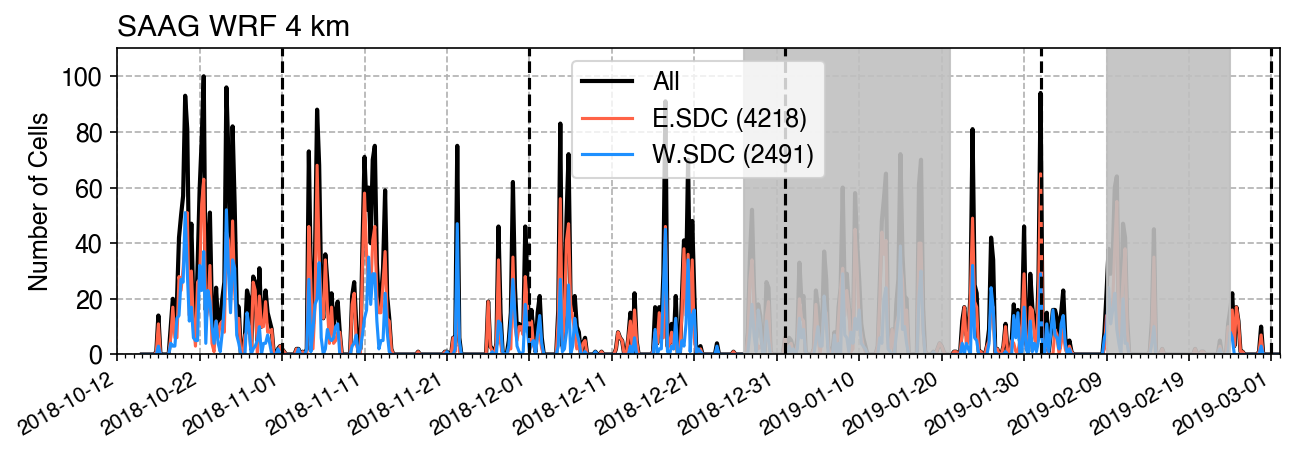

In [29]:
mpl.rcParams['font.size'] = 12
mpl.rcParams['font.family'] = 'Helvetica'
fig, ax = plt.subplots(1, 1, figsize=[10,3], dpi=150)

outtimes1 = [pd.Timestamp('2018-12-27T00'),  pd.Timestamp('2019-2-9T00')]
outtimes2 = [pd.Timestamp('2019-1-21T00'),  pd.Timestamp('2019-2-24T00')]
monthday1 = pd.date_range(start='2018-10-1', end='2019-3-1', freq='1MS')
xlims = [pd.Timestamp('2018-10-12T00'), pd.Timestamp('2019-3-2T00')]

# monthday1 = pd.date_range(start='2018-11-1', end='2019-1-1', freq='1MS')
# xlims = [pd.Timestamp('2018-11-01T00'), pd.Timestamp('2019-1-1T00')]

ax.plot(date_ts, ntracks_ts, color='k', lw=2, label=f'All')
ax.plot(date_ts, ntracks_e_ts, color='tomato', lw=1.5, label=f'E.SDC ({ntracks_e})')
ax.plot(date_ts, ntracks_w_ts, color='dodgerblue', lw=1.5, label=f'W.SDC ({ntracks_w})')
# time_fmt = mdates.DateFormatter('%b %d')
time_fmt = mdates.DateFormatter('%Y-%m-%d')
ax.xaxis.set_major_locator(mdates.DayLocator(interval=10))
ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
ax.xaxis.set_major_formatter(time_fmt)
ax.tick_params(axis='x', labelsize=10)
ax.set_ylabel('Number of Cells')
ax.set_xlim(xlims[0], xlims[1])
ax.set_ylim(0,110)
ax.grid(which='major', ls='--')
ax.set_title('SAAG WRF 4 km', loc='left')
ax.legend()
# Plot outtage times
for ii in range(len(outtimes1)):
    ax.axvspan(outtimes1[ii], outtimes2[ii], color='silver',alpha=0.9,zorder=2)
for ii in range(len(monthday1)):
    ax.axvline(monthday1[ii], color='k', ls='--', lw=1.5)

fig.autofmt_xdate()
fig.savefig(f'{figdir}cellnumber_timeseries_saag_cacti.png', bbox_inches='tight', dpi=300, facecolor='w')

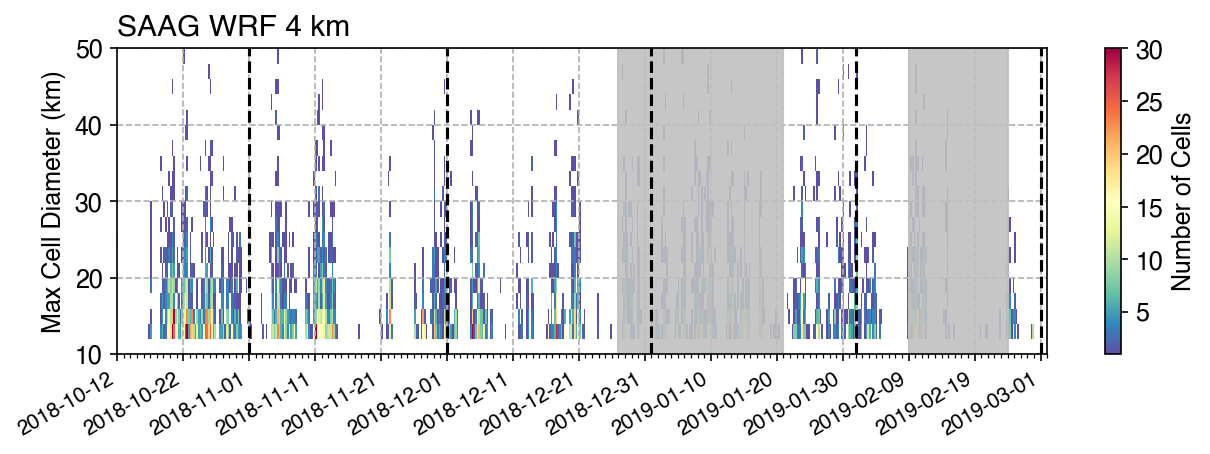

In [30]:
mpl.rcParams['font.size'] = 12
mpl.rcParams['font.family'] = 'Helvetica'
fig, ax = plt.subplots(1, 1, figsize=[10,3], dpi=150)

outtimes1 = [pd.Timestamp('2018-12-27T00'),  pd.Timestamp('2019-2-9T00')]
outtimes2 = [pd.Timestamp('2019-1-21T00'),  pd.Timestamp('2019-2-24T00')]
monthday1 = pd.date_range(start='2018-10-1', end='2019-3-1', freq='1MS')
xlims = [pd.Timestamp('2018-10-12T00'), pd.Timestamp('2019-3-2T00')]

# monthday1 = pd.date_range(start='2018-11-1', end='2019-1-1', freq='1MS')
# xlims = [pd.Timestamp('2018-11-01T00'), pd.Timestamp('2019-1-1T00')]

# ax.plot(date_ts, ntracks_ts, color='k', lw=2, label=f'All')
# ax.plot(date_ts, ntracks_e_ts, color='tomato', lw=1.5, label=f'E.SDC ({ntracks_e})')
# ax.plot(date_ts, ntracks_w_ts, color='dodgerblue', lw=1.5, label=f'W.SDC ({ntracks_w})')
Zm = np.ma.masked_where(celldiam_pdf_ts == 0, celldiam_pdf_ts)
pm1 = ax.pcolormesh(date_ts_bounds, bins_diam, Zm, shading='flat', vmax=30, cmap='Spectral_r')
# time_fmt = mdates.DateFormatter('%b %d')
time_fmt = mdates.DateFormatter('%Y-%m-%d')
ax.xaxis.set_major_locator(mdates.DayLocator(interval=10))
ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
ax.xaxis.set_major_formatter(time_fmt)
ax.tick_params(axis='x', labelsize=10)
ax.set_ylabel('Max Cell Diameter (km)')
ax.set_xlim(xlims[0], xlims[1])
ax.set_ylim(10,50)
ax.grid(which='major', ls='--')
ax.set_title('SAAG WRF 4 km', loc='left')
# ax.legend()
cb1 = plt.colorbar(mappable=pm1, label='Number of Cells')
# Plot outtage times
for ii in range(len(outtimes1)):
    ax.axvspan(outtimes1[ii], outtimes2[ii], color='silver',alpha=0.9,zorder=2)
for ii in range(len(monthday1)):
    ax.axvline(monthday1[ii], color='k', ls='--', lw=1.5)

fig.autofmt_xdate()
fig.savefig(f'{figdir}celldiameter_timeseries_saag_cacti.png', bbox_inches='tight', dpi=300, facecolor='w')